Calculate with error

In [5]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

In [6]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand

import time
from tqdm import trange
# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            #mask = mask & (paras[:,j]>=checkpara[j]-binfs[j]/2)
            #mask = mask & (paras[:,j]<=checkpara[j]+binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))

        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    print(v_to_age(kin_age,p_mr),iso_ave,iso_ave_err)
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

# get average ages
def getkinAges(df,fs,binfs,vbname='v_b'):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        if ('Prot' in fs[i]) or ('Rvar' in fs[i]):
            paras[:,i]=np.log10(df[fs[i]].values)
        else:
            paras[:,i]=df[fs[i]].values
    
    vels=df[vbname].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    return kin_age,v_to_age(kin_age,p_mr)

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX


# get average ages
def getkinAges_err(df,fs,fs_err,binfs,sampsize=50,vbname='v_b'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        print(fs[i])
        newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vbname],df[vbname+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vbname+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vbname=vbname+'_new')
    return ages


def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10    

# Prot

In [20]:
df=pd.read_pickle('minchisq.pkl')
print(np.shape(df))
df=df.dropna(subset=['Prot','teff_calc','abs_G','Prot_err','teff_val_err','abs_G_err']).reset_index(drop=True)
df=df.loc[df['logg']>4]
df=df.loc[abs(df['v_b'])<200]
df=df.loc[df['abs_G']>4]
print(np.shape(df))

(22361, 79)
(21190, 79)


In [21]:
ages=getkinAges_err(df,['Prot','teff_calc','abs_G'],['Prot_err','teff_val_err','abs_G_err'],[0.5,350.0, 0.17333333333333334])


Prot


KeyError: 60

In [39]:
df['kin_age_err_bs']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 


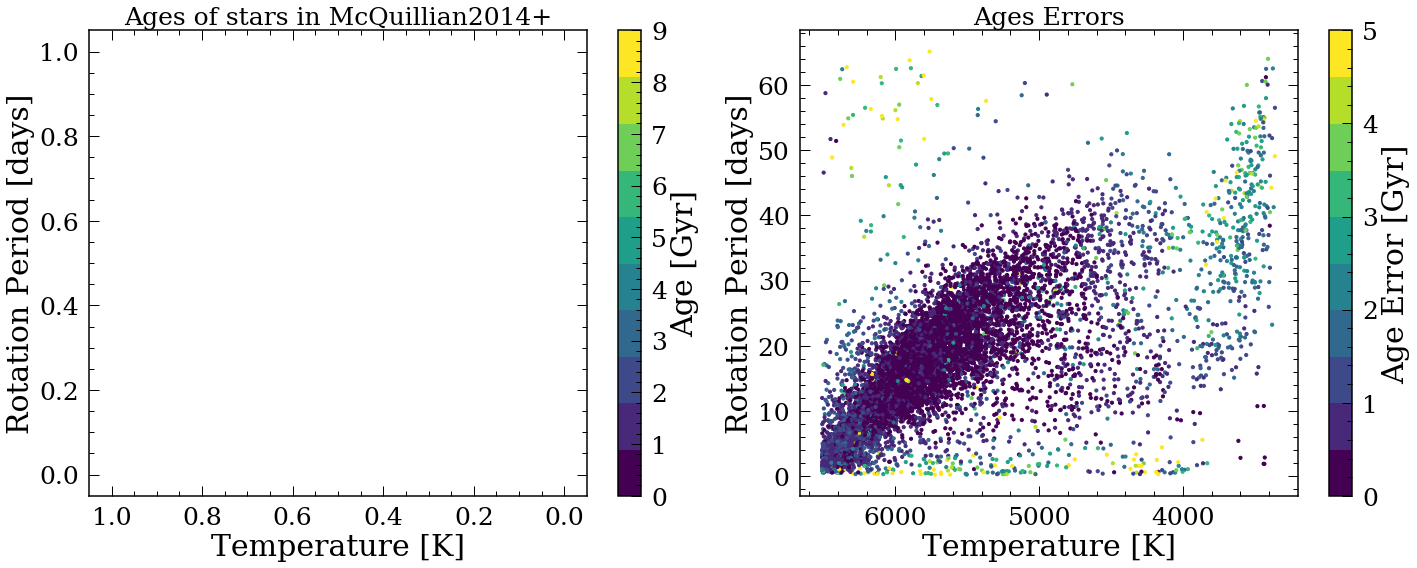

In [19]:
plt.figure(figsize=(20,8))
cm = plt.cm.get_cmap('viridis',10)
plt.subplot(1,2,1)
plt.scatter(df['teff_calc'],df['Prot'],c=df['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')


cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Ages of stars in McQuillian2014+',fontsize=25)

plt.subplot(1,2,2)
plt.scatter(df['teff_calc'],df['Prot'],c=df['kin_age_err_bs'],s=10,vmin=0,vmax=5,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age Error [Gyr]')
plt.title('Ages Errors',fontsize=25)
plt.tight_layout()




In [42]:
df.to_pickle('minchisq.pkl')

(array([ 4.,  2.,  6.,  6., 12.,  6.,  7.,  4.,  0.,  3.]),
 array([0.70389003, 1.02902854, 1.35416705, 1.67930556, 2.00444407,
        2.32958258, 2.65472109, 2.9798596 , 3.30499811, 3.63013663,
        3.95527514]),
 <a list of 10 Patch objects>)

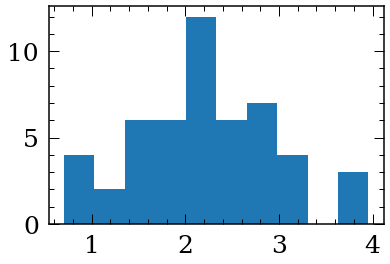

In [63]:
plt.hist(ages[50,:])

# Rvar

In [7]:
df_prot=pd.read_pickle('minchisq.pkl')
df_prot=df_prot[['Prot','Prot_err','KID']]
df_prot=df_prot.drop_duplicates(subset='KID')

z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
   -3.54673368e-01,3.51882114e+02]
p = np.poly1d(z)

KIDs=df_prot['KID'].values

df=pd.read_pickle('KinageAllKepler.pkl')

print(np.shape(df))
df=df.loc[df['abs_G']>p(df['teff_calc'])-0.01]

print(np.shape(df))
df=df.dropna(subset=['Prot_predict','teff_calc','abs_G','teff_val_err','abs_G_err']).reset_index(drop=True)
print(np.shape(df))

Prots=np.zeros(len(df))
Prots_err=np.zeros(len(df))
for i in trange(len(df)):
    df_single=df.iloc[i]
    if df_single['KID'] in KIDs:
        df_prot_single=df_prot.loc[df_prot['KID']==df_single['KID']]
        Prots[i]=df_prot_single['Prot'].values
        Prots_err[i]=df_prot_single['Prot_err'].values
    else:
        Prots[i]=df_single['Prot_predict_2']
        Prots_err[i]=df_single['Prot_predict_2']*0.1

df['Prot_mix']=Prots
df['Prot_mix_err']=Prots_err

df['ML']=np.power(df['mass'],-2.5)*10
df=df.loc[df['kin_age']/df['ML']<0.5]

(55872, 220)
(55872, 220)


  0%|          | 163/52059 [00:00<00:31, 1628.41it/s]

(52059, 220)


100%|██████████| 52059/52059 [00:32<00:00, 1607.07it/s]


In [8]:
df_prot=pd.read_pickle('minchisq.pkl')
df_prot=df_prot.drop_duplicates(subset='KID')
df_prot_add=df_prot.loc[~df_prot['KID'].isin(df['KID'])]
df_prot_add

df = df.loc[:,~df.columns.duplicated()]
df_prot_add = df_prot_add.loc[:,~df_prot_add.columns.duplicated()]

df=df.append(df_prot_add, ignore_index=True, sort=False)
print(np.shape(df))

(38578, 221)


In [9]:
df

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Prot_new,kepid_x,kepid_y,X,Y,z,R,Lz_est,kin_age_Sharma2020,ML
0,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.419571
1,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.882932
2,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.315799
3,893033,0.685,0.027,-0.030,4707.6,87.6,-82.5,4.636,0.018,-0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.727806
4,893286,0.853,0.047,-0.057,5297.1,103.4,-98.5,4.522,0.034,-0.044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.235553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38573,12884404,1.051,0.062,-0.075,5945.6,127.8,-149.6,4.400,0.036,-0.045,...,14.959591,12884404.0,12884404.0,0.155333,-1.353919,0.421869,8.157804,218.082184,0.336984,NaN
38574,12884589,1.007,0.040,-0.052,5889.8,97.1,-95.3,4.465,0.023,-0.033,...,10.626643,12884589.0,12884589.0,0.103367,-0.898058,0.278713,8.146286,197.097074,0.329326,NaN
38575,12934488,0.953,0.074,-0.070,5667.7,107.6,-102.3,4.346,0.042,-0.042,...,52.909462,12934488.0,12934488.0,0.059720,-0.527348,0.163618,8.157344,392.539478,0.077143,NaN
38576,12934525,0.829,0.041,-0.054,5264.3,95.3,-90.7,4.555,0.026,-0.039,...,25.225105,12934525.0,12934525.0,0.099909,-0.882997,0.273805,8.148076,485.459369,0.027671,NaN


In [10]:
df=df.loc[df['abs_G']>p(df['teff_calc'])-0.01]

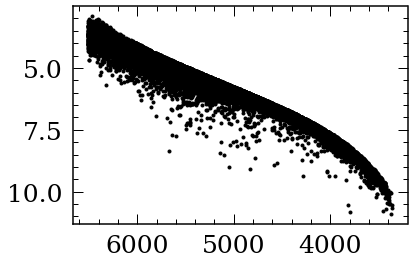

In [11]:
plt.plot(df['teff_calc'],df['abs_G'],'k.')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

df=df.reset_index(drop=True)
#df.to_pickle('KinageAllKepler.pkl')

In [12]:
df

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Prot_new,kepid_x,kepid_y,X,Y,z,R,Lz_est,kin_age_Sharma2020,ML
0,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.419571
1,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.882932
2,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.315799
3,893033,0.685,0.027,-0.030,4707.6,87.6,-82.5,4.636,0.018,-0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.727806
4,893286,0.853,0.047,-0.057,5297.1,103.4,-98.5,4.522,0.034,-0.044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.235553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37488,12884404,1.051,0.062,-0.075,5945.6,127.8,-149.6,4.400,0.036,-0.045,...,14.959591,12884404.0,12884404.0,0.155333,-1.353919,0.421869,8.157804,218.082184,0.336984,NaN
37489,12884589,1.007,0.040,-0.052,5889.8,97.1,-95.3,4.465,0.023,-0.033,...,10.626643,12884589.0,12884589.0,0.103367,-0.898058,0.278713,8.146286,197.097074,0.329326,NaN
37490,12934488,0.953,0.074,-0.070,5667.7,107.6,-102.3,4.346,0.042,-0.042,...,52.909462,12934488.0,12934488.0,0.059720,-0.527348,0.163618,8.157344,392.539478,0.077143,NaN
37491,12934525,0.829,0.041,-0.054,5264.3,95.3,-90.7,4.555,0.026,-0.039,...,25.225105,12934525.0,12934525.0,0.099909,-0.882997,0.273805,8.148076,485.459369,0.027671,NaN


In [86]:
ages=getkinAges_err(df,['Prot_mix','teff_calc','abs_G'],['Prot_mix_err','teff_val_err','abs_G_err'],[0.5,350.,0.17333334])


Prot_mix
teff_calc
abs_G



  0%|          | 0/22317 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in less

  1%|          | 234/22317 [00:00<00:09, 2336.22it/s]

0.0



 22%|██▏       | 4954/22317 [00:01<00:06, 2562.75it/s]


KeyboardInterrupt: 

In [13]:
df['Prot_mix_log']=np.log10(df['Prot_mix'])

In [14]:
#df['kin_age_err_bs']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 

#df['vel_dis'],df['kin_age']=getkinAges(df,['Prot_mix','teff_calc','abs_G'],[0.5,350.,0.17333334],'v_b')
df['vel_dis'],df['kin_age']=getkinAges(df,['Prot_mix','teff_calc','abs_G'],[0.3,100.,0.4],'v_b')


 76%|███████▌  | 28580/37493 [00:11<00:03, 2619.58it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 37493/37493 [00:14<00:00, 2603.35it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


(array([  21.,   31.,   40.,   31.,   46.,   97.,  186.,  262.,  380.,
         410.,  421.,  448.,  401.,  442.,  419.,  391.,  354.,  346.,
         327.,  386.,  393.,  480.,  465.,  496.,  504.,  522.,  586.,
         600.,  679.,  790.,  933., 1115., 1426., 1705., 1749., 1599.,
        1329., 1063.,  949.,  780.,  721.,  697.,  545.,  449.,  382.,
         315.,  277.,  262.,  183.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
        7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8]),
 <a list of 49 Patch objects>)

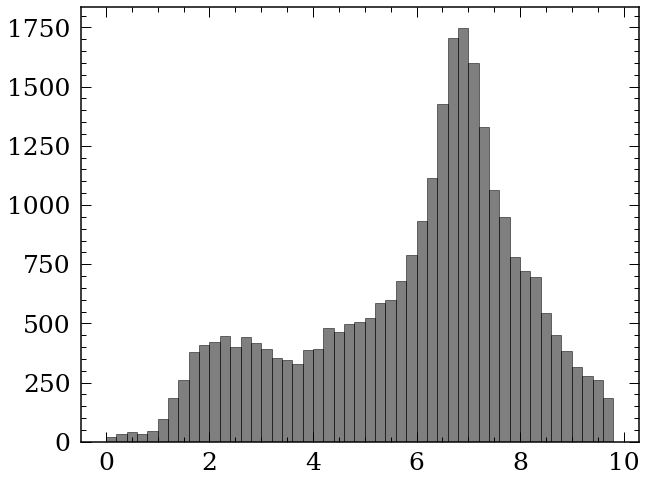

In [15]:
plt.figure(figsize=(10,8))
bins=[i*(1/5) for i in range(50)]
plt.hist(df['kin_age'],bins=bins,alpha=0.5,color='k',edgecolor='k',label='all stars')

In [16]:
df['kin_age'],df['iso_age_ave'],df['iso_age_ave_err']=getAveAges(df,['Prot_mix_log','teff_calc','abs_G'],[0.5,350.,0.17333334])



100%|██████████| 37493/37493 [00:27<00:00, 1370.76it/s]

[6.05510853 6.28578508 3.78987436 ...        nan        nan        nan] [7.0309354  7.07177537 7.44446187 ... 0.         0.         0.        ] [10983.18 10381.55  4273.35 ...     0.       0.       0.  ]



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


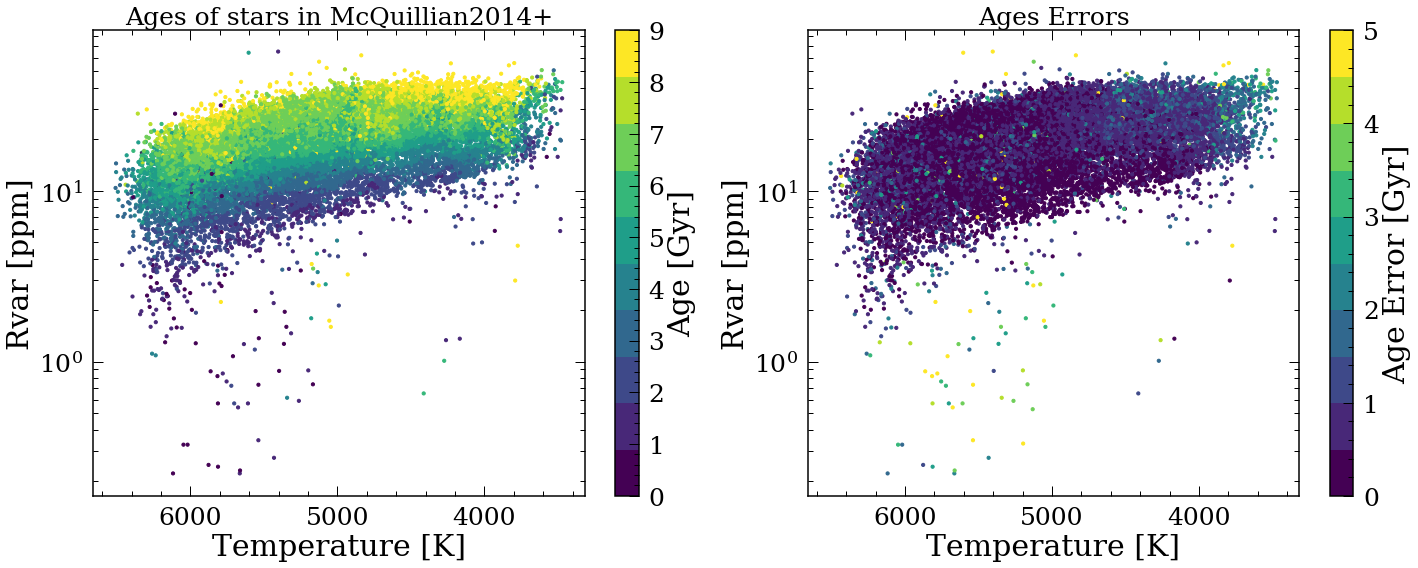

In [17]:
plt.figure(figsize=(20,8))
cm = plt.cm.get_cmap('viridis',10)
plt.subplot(1,2,1)
plt.scatter(df['teff_calc'],df['Prot_mix'],c=df['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rvar [ppm]')
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Ages of stars in McQuillian2014+',fontsize=25)

plt.subplot(1,2,2)
plt.scatter(df['teff_calc'],df['Prot_mix'],c=df['kin_age_err_bs'],s=10,vmin=0,vmax=5,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rvar [ppm]')

cb=plt.colorbar()
plt.yscale('log')
cb.set_label('Age Error [Gyr]')
plt.title('Ages Errors',fontsize=25)
plt.tight_layout()





In [63]:
df['iso_age']

0         9.46
1         6.46
2         3.62
3         6.32
4        14.48
         ...  
77287    15.39
77288    15.34
77289     3.72
77290    11.76
77291     8.62
Name: iso_age, Length: 77292, dtype: float64

In [91]:
df

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Prot_predict_err,Prot_predict_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,Prot_mix,Prot_mix_err,Prot_mix_new,Prot_mix_log
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,1.550170,16.981966,5527.771958,5.247631,-34.159054,0.629617,15.501700,1.550170,13.558202,1.190379
1,892203,0.967,0.073,-0.074,5712.8,108.3,-105.3,4.386,0.042,-0.044,...,3.564443,34.388773,5828.401274,4.596063,13.385110,0.663451,35.644433,3.564443,36.588598,1.551992
2,892675,1.038,0.066,-0.076,5929.4,108.9,-108.1,4.385,0.035,-0.043,...,2.402162,25.580568,5994.087719,4.354274,26.469047,0.328625,24.021617,2.402162,20.973487,1.380602
3,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,3.011637,29.437984,5049.221939,5.901412,-4.878237,0.376141,30.116367,3.011637,33.578639,1.478803
4,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,3.538637,36.491835,4867.640587,5.670129,34.660610,0.586663,35.386367,3.538637,38.916269,1.548836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77287,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,3.520085,33.930979,4568.610180,6.103827,18.897814,0.420507,35.200850,3.520085,34.520320,1.546553
77288,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,3.313600,31.371856,5280.788023,4.373648,-9.888992,0.685754,33.136000,3.313600,42.062564,1.520300
77289,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,1.733028,15.339466,6377.810548,4.236194,5.275711,0.972295,17.330283,1.733028,17.031454,1.238806
77290,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,1.428572,13.092944,5011.666223,5.647343,-0.367072,0.235174,12.059000,0.038000,12.056995,1.081311


In [63]:
df.to_pickle('KinageAllKepler.pkl')